# Problem Set 5, due June 2nd 11:59pm (end of day).

As usual, you are highly encouraged to *start this problem set early!*  My best guess (no guarantees!) is that Part 1 will be conceptually easy but perhaps time consuming.  Parts 2 and 3 are medium difficult, but there are plenty of opportunities to get confused with python data structures, so if you're going to get stuck, get stuck (and unstuck) early! Part 4 will give you an opportunity to get some intuition with PCA.

Note that the two extra credit problems have the potential to be quite challenging and time consuming. Make sure to do everything else in the problem set before you tackle the extra credit.

To get started, download pset5.ipynb and the file "reviews.csv" from Canvas.

I suggest you to get familiar with 'groupby' and
_unique_ functions in 'numpy'.  You will probably also need
_CountVectorizer_ in 'sklearn.feature\_extraction.text' and
_MultinomialNB_ in 'sklearn.naive\_bayes'


In [1]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import sklearn.naive_bayes as nb
import statsmodels.formula.api as smf

from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.decomposition import PCA
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn import metrics

import os

# Introduction

In this assignment, you'll be analyzing movie reviews in an attempt to
determine whether movies are good or bad.  The file "reviews.csv",
contains reviews from the [Rotten Tomatoes](http://www.rottentomatoes.com) website.  I've also put a file "movies.dat" on Canvas that contains metadata for ~65,000 different movies

If you've never seen Rotten Tomatoes before, go spend a few minutes familiarizing yourself with the website.  It's a meta-review website that aggregates movie reviews from a large number of critics.  Note in particular the section on "Critic Reviews" at the bottom -- that's the content that has been scraped and put in the reviews.csv file.  Also note that each movie is given a quantitative score on the Tomatometer which is used to classify the movie as either Fresh or Rotten.

Your mission is to develop a classifier to determine whether a movie is Fresh or Rotten based on the contents of the reviews given to the movie.  As before, we'll start out with some exploratory data analysis.

# 1 Descriptive analysis

Before beginning the "real" work, dig into the data a bit do see what you're dealing with.  Begin by loading the datasets and dropping rows that have missing data, either missing review or missing fresh/rotten indicator.

In [2]:
#Loading data sets
reviews =  pd.read_csv('reviews.csv')
movies = pd.read_table('movies.dat')

In [3]:
#Drop NA's in reviews 
print(reviews.shape)
reviews = reviews.dropna()
print(reviews.shape)

(13442, 9)
(12737, 9)


In [4]:
#Drop NA's in movies 
print(movies.shape)
movies = movies.dropna()
print(movies.shape)

(9423, 21)
(8975, 21)


## 1.1 Basic features of the dataset

Answer the following questions by having your code directly print the
answers:

* How many unique reviews (quotes) are in the `reviews` dataset?
* How many unique reviewers (critics) are in the `reviews` dataset?
* How many unique movies are in the `reviews` dataset?
* How many unique movies are in the *`movies`* dataset?
* How many different publications have reviews in the `reviews` dataset?


In [5]:
print('The reviews dataset has %d unique reviews(quotes).'%reviews.quote.nunique())
print('The reviews dataset has %d unique reviewers(critics).'%reviews.critic.nunique())
print('The reviews dataset has %d unique movies.'%reviews.title.nunique())
print('The movies dataset has %d unique movies.'%movies.title.nunique())
print('The reviews dataset has %d unique publications.'%reviews.publication.nunique())

The reviews dataset has 12167 unique reviews(quotes).
The reviews dataset has 540 unique reviewers(critics).
The reviews dataset has 1715 unique movies.
The movies dataset has 8959 unique movies.
The reviews dataset has 64 unique publications.


## 1.2 Number of reviews per reviewer

Using the `reviews` dataset, create a histogram showing the distribution of the number of reviews per reviewer.  Create the bin width (x-axis) to be 1 unit wide, and the range of the axis to be from 0 to 30.  Scale the y-axis to show the logarithm of (count of) the number of reviews.  Label your axes and make your histogram look professional.

Does the distribution look normal?  Is it what you expect?

In [6]:
reviews_per_critic = reviews.groupby(['critic']).quote.count()

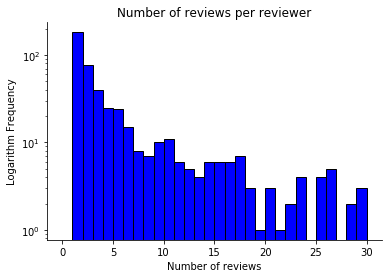

In [7]:
ax = plt.subplot(111)
ax.hist(reviews_per_critic, bins = range(0,31, 1), log = True, color = 'b', edgecolor='black')
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
plt.xlabel('Number of reviews')
plt.ylabel('Logarithm Frequency')
plt.title('Number of reviews per reviewer')

The distribution does not look normal and is skewed to the left. I expected this, as ideally most reviewers would review a small number of films except for prolific reviewers who are in turn smaller in number.

## 1.3 Take a closer look of a few reviews

Find the 30 critics with the most reviews, and list their names in a table along with (a) the name of the publication they work for, (b) the date of their first review, and (c) the date of their last review

*hint: use the groupby function*

In [8]:
critic_detail = reviews.groupby(['critic'], as_index=False).agg({'quote':'count','publication':{'Publication1':'min','Publication2':'max'},'review_date':{'mindate':np.min,'maxdate':np.max}})
critic_detail.columns = ['critic','review_count','First_Publication','Latest_Publication','date_review_first','date_review_last']
top_30 = critic_detail.sort_values(by='review_count',ascending=False).head(30)
top_30

,critic,review_count,First_Publication,Latest_Publication,date_review_first,date_review_last
453,Roger Ebert,1150,At the Movies,Chicago Sun-Times,2000-01-01 00:00:00,2013-06-11 00:00:00
220,James Berardinelli,833,ReelViews,ReelViews,1800-01-01 00:00:00,2012-02-07 00:00:00
228,Janet Maslin,526,New York Times,New York Times,2000-01-01 00:00:00,2010-09-07 00:00:00
529,Variety Staff,450,Variety,Variety,2001-02-13 00:00:00,2012-08-15 00:00:00
285,Jonathan Rosenbaum,420,Chicago Reader,Chicago Reader,1988-07-11 00:00:00,2013-10-22 00:00:00
145,Desson Thomson,375,Washington Post,Washington Post,2000-01-01 00:00:00,2012-10-08 00:00:00
121,Dave Kehr,361,Chicago Reader,New York Daily News,2000-01-01 00:00:00,2013-11-20 00:00:00
194,Geoff Andrew,361,Time Out,Time Out,2005-08-11 00:00:00,2012-04-05 00:00:00
307,Kenneth Turan,282,Los Angeles Times,Los Angeles Times,2000-01-01 00:00:00,2013-10-05 00:00:00
374,Mick LaSalle,282,San Francisco Chronicle,San Francisco Chronicle,2000-01-01 00:00:00,2009-11-25 00:00:00


## 1.4 Ratings over time

Using the `movies` dataset, create a plot that shows how the average rating per movie (rtAllCriticsRating) has evolved over time.  Do this by creating a scatterplot where the x-axis is the year in which the movie was released and the y-axis is rtAllCriticsRating.  Drop movies with 0 or unknown values to avoid biasing your results.  Then, create a scatterplot that has one <year,rating> point for each remaining movie, and pick an appropriate size/color/transparency for these points to ensure that the graph looks professional.  In other words, do not simply use the default settings, as this will produce a dense mess of dots that will be hard to interpret.  Finally, overlay on this scatterplot a line graph in red showing how the average movie rating (the average of rtAllCriticsRating across all movies in a year) has changed over time.  Do you notice a trend?  What do you think it means?

C:\Users\vanlo\Anaconda3\lib\site-packages\ipykernel\__main__.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


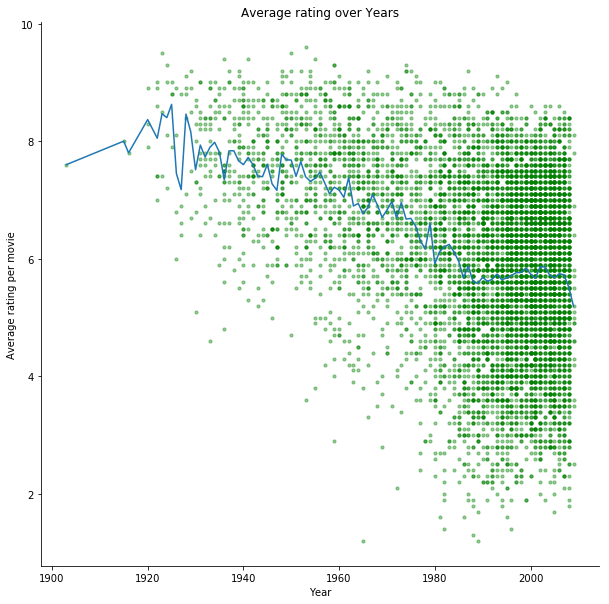

In [9]:
#Drop movies with 0 or unknown values
movies_df = movies[movies.rtAllCriticsRating!='0']

#Convert datatype of rtAllCriticsRating to numeric
movies_df['rtAllCriticsRating'] = movies_df['rtAllCriticsRating'].apply(pd.to_numeric)

#Average movie rating per year
x = movies_df.groupby('year').agg('mean').reset_index()

#Scatterplot
plt.figure(figsize=(10,10))
ax = plt.subplot(111)
ax.scatter(movies_df.year,movies_df.rtAllCriticsRating,color="green", alpha=0.4, s=10)
ax.plot(x.year, x.rtAllCriticsRating)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
plt.xlabel('Year')
plt.ylabel('Average rating per movie')
plt.title('Average rating over Years')

* During the early 1900's, the number of movies reviewed in a year are less as compared to the large number of movies reviewed in the 1990's and 2000's.
* The average movie rating per year seems to be decreasing over the years. This is possibly due to the large number of movies being reviewed in the later years.

# Part 2: Naive Bayes

Now it gets fun!  You are going to use a Naive Bayes classifier to build a prediction model for whether a review is fresh or rotten, depending on the text of the review. 

## 2.0 Using CountVectorizer

One thing that may help you in the following problems is the _CountVectorizer_ object in Scikit-learn.  This will help you convert your raw text fields into "bag of words" vectors, i.e. a data structure that tells you how many times a particular word appears in the text.  (Note: the order of wordss is not preserved in the bag).   Here's a simple example, make sure you understand what's going on!

In [10]:
from sklearn.feature_extraction.text import CountVectorizer

sentences = ["Next morning when I awakened I found Jem and Dill in the back yard deep in conversation.", "When I joined them, as usual they said go away.", "Will not.", "This yard's as much mine as it is your, Jem Finch.", "I got just as much right to play in it as you have."]
# Harper Lee "To Kill a Mockingbrid"
print ("Original text:\n", "\n".join(sentences))

vectorizer = CountVectorizer(min_df=0)
vectorizer.fit(sentences)
# `fit` builds the vocabulary
x = vectorizer.transform(sentences).toarray()
# `transform` converts text to a bag of words
print ("Transformed text vector:\n", x)

# `get_feature_names` tracks which word is associated with each column of the transformed x
print ("Words for each feature:")
print (vectorizer.get_feature_names())

Original text:
 Next morning when I awakened I found Jem and Dill in the back yard deep in conversation.
When I joined them, as usual they said go away.
Will not.
This yard's as much mine as it is your, Jem Finch.
I got just as much right to play in it as you have.
Transformed text vector:
 [[1 0 1 0 1 1 1 1 0 1 0 0 0 2 0 0 1 0 0 0 1 0 1 0 0 0 0 1 0 0 0 0 0 1 0 1
  0 0]
 [0 1 0 1 0 0 0 0 0 0 1 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 1 0 1 1 0 0 1 1 0 0
  0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 1 0
  0 0]
 [0 2 0 0 0 0 0 0 1 0 0 0 0 0 1 1 1 0 0 1 0 1 0 0 0 0 0 0 0 0 1 0 0 0 0 1
  0 1]
 [0 2 0 0 0 0 0 0 0 0 0 1 1 1 0 1 0 0 1 0 0 1 0 0 1 1 0 0 0 0 0 1 0 0 0 0
  1 0]]
Words for each feature:
['and', 'as', 'awakened', 'away', 'back', 'conversation', 'deep', 'dill', 'finch', 'found', 'go', 'got', 'have', 'in', 'is', 'it', 'jem', 'joined', 'just', 'mine', 'morning', 'much', 'next', 'not', 'play', 'right', 'said', 'the', 'them', 'they', 'this', 'to', 'usual', 'when', '

## 2.1 Create your X input and Y output

Using the `reviews` dataframe, compute a pair of numerical X, Y arrays where:
    
 * X is a `(nreview, nwords)` array. Each row is the bag-of-words representation for a single review.  This will be the *input* (fetaures) of your model.
 * Y is a `nreview`-element 1/0 array, encoding whether a review is Fresh (1) or Rotten (0). This is the desired *output* (target) from your model.
 
 Make sure to remove items with no review text

Feel free to use the _make\_xy_ function below to achieve it, but you can also create your own parser.

In [11]:
"""
Function
--------
make_xy

Build a bag-of-words training set for the review data

Parameters
-----------
reviews : Pandas DataFrame
    The review data from above
    
vectorizer : CountVectorizer object (optional)
    A CountVectorizer object to use. If None,
    then create and fit a new CountVectorizer.
    Otherwise, re-fit the provided CountVectorizer
    using the reviews data
    
Returns
-------
X : numpy array (dims: nreview, nwords)
    Bag-of-words representation for each review.
Y : numpy array (dims: nreview)
    1/0 array. 1 = fresh review, 0 = rotten review

Examples
--------
X, Y = make_xy(reviews)
"""
def make_xy(critics, vectorizer=None):
    #Your code here    
    if vectorizer is None:
        vectorizer = CountVectorizer()
    X = vectorizer.fit_transform(critics.quote)
    X = X.tocsc()  # some versions of sklearn return COO format
    Y = (critics.fresh == 'fresh').values.astype(np.int)
    return X, Y

In [12]:
X, Y = make_xy(reviews)

## 2.2 Test-Train split

Next, randomly split the data into two groups: a training (75%) set and a validation set (25%).  You can do this manually, as you have done earlier, but I recommend to use `train_test_split` in 'sklearn.model_selection'.

In [13]:
X_train, X_test, y_train, y_test = train_test_split(X,Y,test_size=0.25)

## 2.3 Naive Bayes with `MultinomialNB`
Use the training set to train a Naive Bayes classifier using the `MultinomialNB` from 'sklearn'.  Play with _MultinomialNB_ parameters.  Report the accuracy of this model on both the training and testing data.  What do you observe?  Interpret these results!

*Hint: This shouldn't take more than 5-10 lines of code to accomplish*



In [14]:
clf = MultinomialNB()
clf.fit(X_train, y_train)

training_score = clf.score(X_train, y_train)
test_predictions = clf.predict(X_test)

training_score = training_score*100
test_predictions = metrics.accuracy_score(y_test,test_predictions) * 100

print('Training accuracy is: %f' %training_score)
print('Testing accuracy is : %f' %test_predictions)

Training accuracy is: 92.336683
Testing accuracy is : 77.927786


# 3 Evaluation

## 3.1 Estimate the likelihood of your data

Calculate log-likelihood of a fitted model.  Log-likelihood is a way to assess the performance of your model.  Remeber -- likelihood is more-or-less the probability to observe your data (including your target).  Below is an example function that calculates the log-likelihood of an estimated model using `fitted_model.predict_logproba`.  You may use this function, or write your own.  

In [15]:
"""
Function
--------
log_likelihood

Compute the log likelihood of a dataset according to a bayesian classifier. 

The Log Likelihood is defined by

L = Sum_fresh(logP(fresh)) + Sum_rotten(logP(rotten))

Where Sum_fresh indicates a sum over all fresh reviews, 
and Sum_rotten indicates a sum over rotten reviews.

Parameters
----------
model : Bayesian classifier
x : (nexample, nfeature) array
    The input data
y : (nexample) integer array
    Whether each review is Fresh
"""

def log_likelihood(model, x, y):
    prob = model.predict_log_proba(x)
    # returns Nx2 array.  Columns are log(Pr(y == 0|x)), log(Pr(y==1|x))
    ll = prob[y == 0, 0].sum() + prob[y == 1, 1].sum()
    return ll

## 3.2 Cross-Validation

Why do we care about the log-likelihood of our data?  You guessed it: Cross-Validation.

Our classifier has a few hyperparameters. The two most important are:

 1. The `min_df` keyword in `CountVectorizer`, which will ignore words which appear in fewer than `min_df` fraction of reviews. Words that appear only once or twice can lead to overfitting, since words which occur only a few times might correlate very well with Fresh/Rotten reviews by chance in the training dataset.
 
 2. The `alpha` keyword in the Bayesian classifier is a "smoothing parameter" -- increasing the value decreases the sensitivity to any single feature, and tends to pull prediction probabilities closer to 50%. 

We are going to use cross-validation to tune these hyperparameters.  The objective function we want to maximize is the log-likelihood of our data.  Fill in the remaining code in this block, to loop over many values of `alpha` and `min_df` to determine
which settings are "best" in the sense of maximizing the cross-validated log-likelihood.

*hint: sklearn has a built-in function, `sklearn.model_selection.cross_val_score`, that might save you a lot of time here...*

In [16]:
def make_xy_2(critics, vectorizer=None, min_df = None):
    if vectorizer is None:
        vectorizer = CountVectorizer(min_df=min_df)
    X = vectorizer.fit_transform(critics.quote)
    X = X.tocsc()  # some versions of sklearn return COO format
    Y = (critics.fresh == 'fresh').values.astype(np.int)
    return X, Y, vectorizer.get_feature_names()

In [17]:
#the grid of parameters to search over
alphas = [0, .1, 1, 5, 10, 50]
min_dfs = [1e-5, 1e-4, 1e-3, 1e-2, 1e-1]
for alpha in alphas:
    print ('For alpha : %f' %alpha)
    for min_df in min_dfs:
        print ('min_df : %f' %min_df)
        X, Y, feature_list = make_xy_2(reviews, min_df = min_df)
        clf = MultinomialNB(alpha = alpha, class_prior=None, fit_prior=True)
        print (cross_val_score(clf, X, Y, scoring = log_likelihood).mean())
    print (' ')

For alpha : 0.000000
min_df : 0.000010


C:\Users\vanlo\Anaconda3\lib\site-packages\sklearn\naive_bayes.py:699: RuntimeWarning: divide by zero encountered in log
  self.feature_log_prob_ = (np.log(smoothed_fc) -
C:\Users\vanlo\Anaconda3\lib\site-packages\sklearn\utils\extmath.py:410: RuntimeWarning: invalid value encountered in subtract
  out = np.log(np.sum(np.exp(arr - vmax), axis=0))
C:\Users\vanlo\Anaconda3\lib\site-packages\sklearn\naive_bayes.py:699: RuntimeWarning: divide by zero encountered in log
  self.feature_log_prob_ = (np.log(smoothed_fc) -
C:\Users\vanlo\Anaconda3\lib\site-packages\sklearn\utils\extmath.py:410: RuntimeWarning: invalid value encountered in subtract
  out = np.log(np.sum(np.exp(arr - vmax), axis=0))
C:\Users\vanlo\Anaconda3\lib\site-packages\sklearn\naive_bayes.py:699: RuntimeWarning: divide by zero encountered in log
  self.feature_log_prob_ = (np.log(smoothed_fc) -
C:\Users\vanlo\Anaconda3\lib\site-packages\sklearn\utils\extmath.py:410: RuntimeWarning: invalid value encountered in subtract
  ou

nan
min_df : 0.000100


C:\Users\vanlo\Anaconda3\lib\site-packages\sklearn\naive_bayes.py:699: RuntimeWarning: divide by zero encountered in log
  self.feature_log_prob_ = (np.log(smoothed_fc) -
C:\Users\vanlo\Anaconda3\lib\site-packages\sklearn\utils\extmath.py:410: RuntimeWarning: invalid value encountered in subtract
  out = np.log(np.sum(np.exp(arr - vmax), axis=0))
C:\Users\vanlo\Anaconda3\lib\site-packages\sklearn\naive_bayes.py:699: RuntimeWarning: divide by zero encountered in log
  self.feature_log_prob_ = (np.log(smoothed_fc) -
C:\Users\vanlo\Anaconda3\lib\site-packages\sklearn\utils\extmath.py:410: RuntimeWarning: invalid value encountered in subtract
  out = np.log(np.sum(np.exp(arr - vmax), axis=0))
C:\Users\vanlo\Anaconda3\lib\site-packages\sklearn\naive_bayes.py:699: RuntimeWarning: divide by zero encountered in log
  self.feature_log_prob_ = (np.log(smoothed_fc) -
C:\Users\vanlo\Anaconda3\lib\site-packages\sklearn\utils\extmath.py:410: RuntimeWarning: invalid value encountered in subtract
  ou

nan
min_df : 0.001000


C:\Users\vanlo\Anaconda3\lib\site-packages\sklearn\naive_bayes.py:699: RuntimeWarning: divide by zero encountered in log
  self.feature_log_prob_ = (np.log(smoothed_fc) -
C:\Users\vanlo\Anaconda3\lib\site-packages\sklearn\utils\extmath.py:410: RuntimeWarning: invalid value encountered in subtract
  out = np.log(np.sum(np.exp(arr - vmax), axis=0))
C:\Users\vanlo\Anaconda3\lib\site-packages\sklearn\naive_bayes.py:699: RuntimeWarning: divide by zero encountered in log
  self.feature_log_prob_ = (np.log(smoothed_fc) -
C:\Users\vanlo\Anaconda3\lib\site-packages\sklearn\utils\extmath.py:410: RuntimeWarning: invalid value encountered in subtract
  out = np.log(np.sum(np.exp(arr - vmax), axis=0))
C:\Users\vanlo\Anaconda3\lib\site-packages\sklearn\naive_bayes.py:699: RuntimeWarning: divide by zero encountered in log
  self.feature_log_prob_ = (np.log(smoothed_fc) -
C:\Users\vanlo\Anaconda3\lib\site-packages\sklearn\utils\extmath.py:410: RuntimeWarning: invalid value encountered in subtract
  ou

nan
min_df : 0.010000
-2675.199762192071
min_df : 0.100000
-2761.6608409217224
 
For alpha : 0.100000
min_df : 0.000010
-3731.5972913504247
min_df : 0.000100
-3732.8652709999897
min_df : 0.001000
-2686.834936876536
min_df : 0.010000
-2674.9022136682843
min_df : 0.100000
-2761.659023899852
 
For alpha : 1.000000
min_df : 0.000010
-2543.882085483101
min_df : 0.000100
-2499.881162129589
min_df : 0.001000
-2492.04691484011
min_df : 0.010000
-2672.3737501196492
min_df : 0.100000
-2761.6429534771546
 
For alpha : 5.000000
min_df : 0.000010
-4332.653610612579
min_df : 0.000100
-3104.801618833068
min_df : 0.001000
-2358.8273714373845
min_df : 0.010000
-2663.8077105946213
min_df : 0.100000
-2761.5775723671454
 
For alpha : 10.000000
min_df : 0.000010
-5876.440099693719
min_df : 0.000100
-4432.618971133806
min_df : 0.001000
-2422.19881316915
min_df : 0.010000
-2657.4995838665454
min_df : 0.100000
-2761.509213575368
 
For alpha : 50.000000
min_df : 0.000010
-7285.83928361016
min_df : 0.000100
-66

## 3.3 Putting it together

Now that you've determined values for alpha and min_df that optimize the cross-validated log-likelihood, repeat the steps in 2.1-2.3 to train a final classifier with these parameters and re-evaluate the accuracy.  Discuss the various ways in which Cross-Validation has affected the model. Is the new model more or less accurate? Is overfitting better or worse?

In [34]:
X, Y, feature_list = make_xy_2(reviews, min_df = 0.001)
X_df = pd.DataFrame(X.toarray())
Y_df = pd.DataFrame(Y, columns =['Target'])
data = pd.concat([X_df,Y_df], axis = 1)

X_train, X_test, y_train, y_test = train_test_split(X,Y,test_size=0.25)

clf_new = MultinomialNB(alpha = 5, class_prior=None, fit_prior=True)
clf_new.fit(X_train,y_train)
train_predicted = clf_new.predict(X_train)
test_predicted = clf_new.predict(X_test)

train_accuracy = metrics.accuracy_score(y_train,train_predicted) * 100
test_accuracy = metrics.accuracy_score(y_test,test_predicted) * 100

print('Training accuracy is: %f' %train_accuracy)
print('Testing accuracy is : %f' %test_accuracy)

Training accuracy is: 79.250419
Testing accuracy is : 75.384615


## 3.5 Interpretation

What words best predict a fresh or rotten review?  Using your classifier and the `vectorizer.get_feature_names` method, determine which words best predict a positive or negative review. Print the 10 words that best predict a "fresh" review, and the 10 words that best predict a "rotten" review. For each word, what is the model's probability of freshness if the word appears one time?

#### Hints
* In thinking about how to measure the impact of a word on freshness rating, consider computing the classification probability for a feature vector which consists of all 0s, except for a single 1. What does this probability refer to?
* `numpy.identity` generates an identity matrix, where all values are zero except the diagonal elements which have a value of one

In [35]:
probs_for_each_feature = clf_new.predict_proba(np.identity(len(feature_list)))
prob_df = pd.DataFrame(probs_for_each_feature, columns =['rotten','fresh'])
prob_df.head()

,rotten,fresh
0,0.461851,0.538149
1,0.281945,0.718055
2,0.219033,0.780967
3,0.438266,0.561734
4,0.438266,0.561734


In [36]:
sort_df = prob_df.sort_values(['fresh'], axis = 0, ascending = False)

In [37]:
positive_reviews = list(sort_df.iloc[:10].index)
feature_list = np.array(feature_list)
print(feature_list[positive_reviews])

['delight' 'masterpiece' 'remarkable' 'stunning' 'rare' 'beautiful'
 'intelligent' 'intimate' 'captures' 'witty']


In [38]:
sort_negative_df = prob_df.sort_values(['rotten'], axis = 0, ascending = False)
negative_reviews = list(sort_negative_df.iloc[:10].index)
print (feature_list[negative_reviews])

['unfortunately' 'pointless' 'uninspired' 'lame' 'fails' 'problem' 'dull'
 'disappointment' 'bland' 'unfunny']


## Part 4: Principal Component Analysis

Just when you thought you were *finally* done with the [Boston Housing Prices Data Set](http://archive.ics.uci.edu/ml/datasets/Housing), it has come back to haunt you for a few more minutes.  Make sure you're up and running as you were on the previous problem set:

In [39]:
from sklearn.datasets import load_boston
bdata = load_boston()
print ("keys:", bdata.keys())
print ("feature names:",  bdata.feature_names)
print ("data shape:", bdata.data.shape)
print ("target shape", bdata.target.shape)
#print (bdata.DESCR)
print ("-"*80)
features = bdata.feature_names
df = pd.DataFrame(bdata.data,columns = bdata.feature_names)
df['MEDV'] = bdata.target
df.head()

keys: dict_keys(['data', 'target', 'feature_names', 'DESCR'])
feature names: ['CRIM' 'ZN' 'INDUS' 'CHAS' 'NOX' 'RM' 'AGE' 'DIS' 'RAD' 'TAX' 'PTRATIO'
 'B' 'LSTAT']
data shape: (506, 13)
target shape (506,)
--------------------------------------------------------------------------------


,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,MEDV
0,0.00632,18.0,2.31,0.0,0.538,6.575,65.2,4.0900,1.0,296.0,15.3,396.90,4.98,24.0
1,0.02731,0.0,7.07,0.0,0.469,6.421,78.9,4.9671,2.0,242.0,17.8,396.90,9.14,21.6
2,0.02729,0.0,7.07,0.0,0.469,7.185,61.1,4.9671,2.0,242.0,17.8,392.83,4.03,34.7
3,0.03237,0.0,2.18,0.0,0.458,6.998,45.8,6.0622,3.0,222.0,18.7,394.63,2.94,33.4
4,0.06905,0.0,2.18,0.0,0.458,7.147,54.2,6.0622,3.0,222.0,18.7,396.90,5.33,36.2


### 4.1 Remember the last problem set?

Use matplotlib to create a scatter plot that shows the relationship between the median value of the home (y-axis) and the per-capita crime rate (x-axis).  Properly label your axes, and make sure that your graphic looks polished and professional.  If you didn't get full credit for this on the first problem set, get full credit this time!

Then, just as you did on the previous problem set, use the [Linear Regression class](http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LinearRegression.html) from sklearn or the [OLS class](http://wiki.scipy.org/Cookbook/OLS) from SciPy to regress median housing price on average number of rooms per house.  Use a training set consisting of 66% of your instances to fit your regression model.  Report the RMSE on the training and test set.

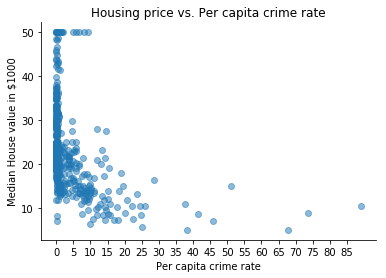

In [19]:
#Combining the data with the target median values
bdata_df = np.insert(bdata.data, bdata.data.shape[1], bdata.target, axis = 1)
ax = plt.subplot(111)
ax.scatter(bdata_df[:,0],bdata_df[:,13], alpha = 0.5)
plt.xlabel('Per capita crime rate')
plt.ylabel('Median House value in $1000')
plt.title('Housing price vs. Per capita crime rate')
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
plt.xticks(np.arange(min(bdata_df[:,0]),max(bdata_df[:,0])+1,5.0))
plt.show()

In [20]:
bd_train, bd_test = train_test_split(df, test_size = 0.34)

mod_train = smf.ols(formula = 'MEDV ~ RM', data = bd_train).fit()
print (mod_train.summary())
print (mod_train.params)

                            OLS Regression Results                            
Dep. Variable:                   MEDV   R-squared:                       0.459
Model:                            OLS   Adj. R-squared:                  0.457
Method:                 Least Squares   F-statistic:                     280.8
Date:                Mon, 05 Feb 2018   Prob (F-statistic):           4.49e-46
Time:                        21:32:27   Log-Likelihood:                -1103.6
No. Observations:                 333   AIC:                             2211.
Df Residuals:                     331   BIC:                             2219.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
Intercept    -34.7281      3.429    -10.128      0.0

In [21]:
mod_test = smf.ols(formula = 'MEDV ~ RM', data = bd_test).fit()
print (mod_test.summary())
print (mod_test.params)

                            OLS Regression Results                            
Dep. Variable:                   MEDV   R-squared:                       0.526
Model:                            OLS   Adj. R-squared:                  0.524
Method:                 Least Squares   F-statistic:                     190.0
Date:                Mon, 05 Feb 2018   Prob (F-statistic):           1.51e-29
Time:                        21:32:29   Log-Likelihood:                -569.38
No. Observations:                 173   AIC:                             1143.
Df Residuals:                     171   BIC:                             1149.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
Intercept    -34.5774      4.190     -8.251      0.0

In [40]:
# Function : Compute RMSE
def compute_rmse(predictions,yvalues):
    x = np.square(np.asarray(predictions)- np.asarray(yvalues))
    s = x.size + 0.0
    y = np.sqrt(np.sum(x) * np.reciprocal(s))
    return (round(y,2)) 

In [41]:
y_predicted_train = mod_train.params.Intercept + mod_train.params.RM*bd_train['RM']
rmse = compute_rmse(y_predicted_train, bd_train.iloc[:,-1])
print ('RMSE for train model : ' ,rmse)

y_predicted_test = mod_test.params.Intercept + mod_test.params.RM*bd_test['RM']
rmse = compute_rmse(y_predicted_test, bd_test.iloc[:,-1])
print ('RMSE for test model : ' ,rmse)

RMSE for train model :  6.65
RMSE for test model :  6.5


### 4.2 So many scatterplots!

Choose 8 out of the of the 14 features of the housing data that you think are most interesting to study.  Create an 8x8 grid of scatterplots showing how each of these variables relate to each other.  You want to produce something that looks generally like [this image](http://iogas.net/wp-content/gallery/iogas-evaluation/scatterplot-matrix-point-density.png).

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x000001D0A71E03C8>,
      dtype=object)

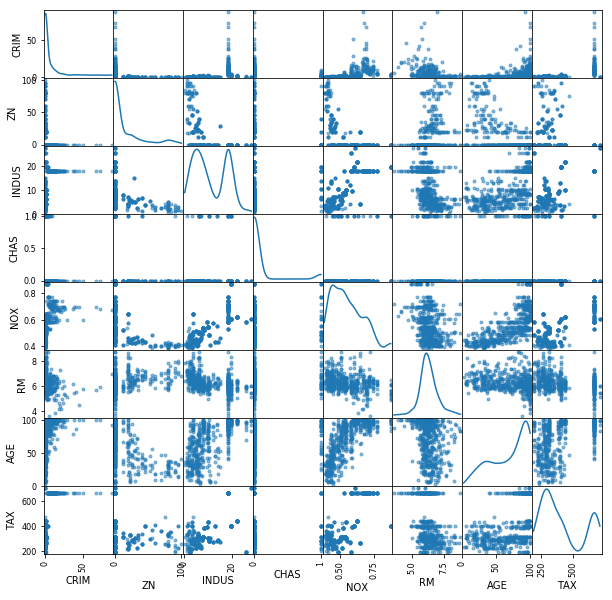

In [24]:
from pandas.tools.plotting import scatter_matrix
df_subset = df.loc[:,['CRIM','ZN','INDUS','CHAS','NOX','RM','AGE','TAX']]
scatter_matrix(df_subset, figsize=(10, 10), diagonal='kde')

### 4.3 PCA to the rescue

Run principal component analysis using [PCA](http://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html) from sklearn to find the first 12 principal components of your data.  Use only your training set (66% of the data), and use all features *except* the median housing price.  Create a figure showing how the amount of variance explained by your components increases as you increase the number of components from 1 to 12.

[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]
[0.7976848792782073, 0.966948236452689, 0.9893996085341313, 0.9967539797049013, 0.9984579928980001, 0.9991817958206576, 0.9996097163138065, 0.9998888135516636, 0.999962469604898, 0.9999921348875487, 0.9999986051254102, 0.9999999211248778]


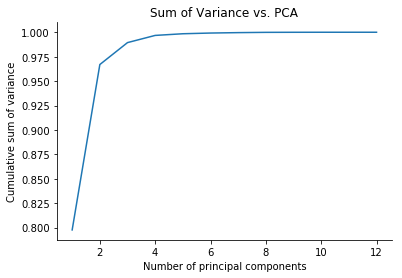

In [25]:
X_train = bd_train.ix[:, bd_train.columns != 'MEDV']
components = range(1,13)
temp_i = []
temp_sum_variance = []
for i in components:
    pca = PCA(n_components=i)
    pca.fit(X_train)
    sum_variance = np.sum(pca.explained_variance_ratio_)
    temp_i.append(i)
    temp_sum_variance.append(sum_variance)
print(temp_i)
print(temp_sum_variance)
ax = plt.subplot(111)
ax.plot(temp_i,temp_sum_variance)
plt.xlabel('Number of principal components')
plt.ylabel('Cumulative sum of variance')
plt.title('Sum of Variance vs. PCA')
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
plt.show()

### 4.4 Visualizing the components

Create a 1X3 grid containing three scatter plots of your training data:

1. PCA 1 vs. PCA 2 (you will need to use `fit_transform` to project your training data onto these two components)
2. PCA 1 (x-axis) vs. median housing value
3. PCA 2 vs. median housing value

In [26]:
pca2 = PCA(n_components = 2)
X = pd.DataFrame(pca2.fit_transform(X_train), columns =['PCA1','PCA2'])
X = pd.concat([X,bd_train.iloc[:,-1]], axis = 1)

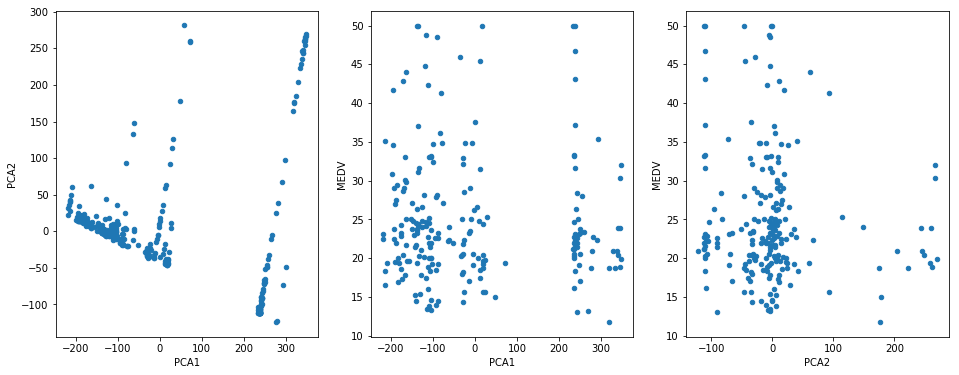

In [27]:
fig, ax = plt.subplots(1,3)
X.plot('PCA1', 'PCA2', kind = 'scatter', ax = ax[0], figsize= (16,6))
X.plot('PCA1', 'MEDV', kind = 'scatter', ax = ax[1])
X.plot('PCA2', 'MEDV', kind = 'scatter', ax = ax[2])

### 4.5 Regression and PCA

Using just the first Principal Component learned on the training data, project all of your data (including the test data) onto this 1-dimensional subspace using the `fit_transform` function.  Now, using your training data, fit a regression of median housing price on this first principal component of your data.  Report the RMSE of this regression for both the training and test set.  How do these results compare to your results from 4.1?  Interpret your results!

In [28]:
pca3 = PCA(n_components = 1)
pca3.fit(X_train)

PCA(copy=True, iterated_power='auto', n_components=1, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False)

In [29]:
PCA1 = pd.DataFrame(pca3.fit_transform(df), columns =['PCA'])
medv = df['MEDV']
total_data = pd.concat([PCA1, medv], axis = 1)

In [30]:
pca_train, pca_test = train_test_split(total_data, test_size=0.34)

In [31]:
mod1 = smf.ols(formula="MEDV ~ PCA", data=pca_train, missing = 'drop').fit()
print (mod1.params)
print (mod1.summary())

Intercept    22.79593
PCA          -0.02531
dtype: float64
                            OLS Regression Results                            
Dep. Variable:                   MEDV   R-squared:                       0.219
Model:                            OLS   Adj. R-squared:                  0.217
Method:                 Least Squares   F-statistic:                     92.96
Date:                Mon, 05 Feb 2018   Prob (F-statistic):           1.50e-19
Time:                        21:32:58   Log-Likelihood:                -1175.0
No. Observations:                 333   AIC:                             2354.
Df Residuals:                     331   BIC:                             2362.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [95.0% Conf. Int.]
------------------------------------------------------------------------

In [43]:
mod2 = smf.ols(formula="MEDV ~ PCA", data=pca_test, missing = 'drop').fit()
print (mod2.params)
print (mod2.summary())

Intercept    22.029849
PCA          -0.025700
dtype: float64
                            OLS Regression Results                            
Dep. Variable:                   MEDV   R-squared:                       0.275
Model:                            OLS   Adj. R-squared:                  0.271
Method:                 Least Squares   F-statistic:                     65.02
Date:                Mon, 05 Feb 2018   Prob (F-statistic):           1.24e-13
Time:                        21:36:04   Log-Likelihood:                -595.01
No. Observations:                 173   AIC:                             1194.
Df Residuals:                     171   BIC:                             1200.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [95.0% Conf. Int.]
----------------------------------------------------------------------

In [44]:
y_predicted_pca_train = mod1.params.Intercept + mod1.params.PCA*pca_train['PCA']
rmse = compute_rmse(y_predicted_pca_train, pca_train.iloc[:,-1])
print ('RMSE for train model after PCA : ' ,rmse)

y_predicted_pca_test = mod2.params.Intercept + mod2.params.PCA*pca_test['PCA']
rmse = compute_rmse(y_predicted_pca_test, pca_test.iloc[:,-1])
print ('RMSE for test model after PCA : ' ,rmse)

RMSE for train model after PCA :  8.24
RMSE for test model after PCA :  7.54
